# Autoencoder Using ANN.

We're using an artificial neural network in the encoder and decoder architectures.

## Encoder
The encoder has 1 input layer and 1 hidden layer having 256 nodes with ReLU as activation.

## Latent Space Representation
The latent space representation or code has 7 hidden nodes. So, we're compressing the 28*28 image into a 1D vector of size 7.

## Decoder
The decoder has 1 hidden layer having 256 nodes followed by ReLU activation. The output layer has 28*28 nodes followed by Sigmoid as activation.

In [27]:
import os
import torch
import numpy as np
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision.transforms import v2 as transforms

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# convert data to torch.FloatTensor
transform = transforms.Compose([
    transforms.PILToTensor(),
    transforms.ToDtype(torch.float32, scale=True),
])

# load the training and test datasets
train_data = datasets.MNIST(root='./data', train=True,
                                   download=True, transform=transform)
test_data = datasets.MNIST(root='./data', train=False,
                                  download=True, transform=transform)

num_workers = os.cpu_count()
batch_size = 32

train_loader = DataLoader(train_data, batch_size, shuffle=True, num_workers=num_workers)
test_loader = DataLoader(test_data, batch_size, shuffle=False, num_workers=num_workers)

(32, 1, 28, 28)


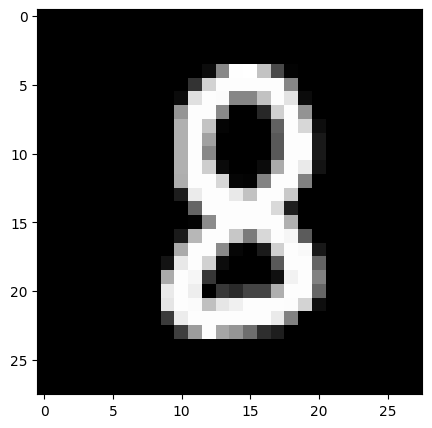

In [28]:
import matplotlib.pyplot as plt
%matplotlib inline

# obtain one batch of training images
images, labels = next(iter(train_loader))
images = images.numpy()
print(images.shape)

# get one image from the batch
img = np.squeeze(images[0])
fig = plt.figure(figsize = (5,5))
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')

In [29]:
import torch.nn as nn

class Autoencoder(nn.Module):
  def __init__(self, encoding_dim):
    super().__init__()

    self.encoder = nn.Sequential(
        nn.Flatten(),
        nn.Linear(28*28, 256),
        nn.ReLU(),
        nn.Linear(256, encoding_dim),
        nn.ReLU()
    )

    self.decoder = nn.Sequential(
        nn.Linear(encoding_dim, 256),
        nn.ReLU(),
        nn.Linear(256, 28*28),
        nn.Sigmoid()
    )

  def forward(self, x):
    return self.decoder(self.encoder(x))

encoding_dim = 7
model = Autoencoder(encoding_dim).to(device)
print(model)

Autoencoder(
  (encoder): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=256, bias=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=7, bias=True)
    (4): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=7, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=784, bias=True)
    (3): Sigmoid()
  )
)


In [30]:
loss_fn = nn.MSELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [32]:
n_epochs = 20
for epoch in range(1, n_epochs+1):
  train_loss = 0

  model.train()
  for images, _ in train_loader:
    current_batch_size = images.size(0)
    optimizer.zero_grad()
    outputs = model(images).view(current_batch_size, 1, 28, 28)
    loss = loss_fn(outputs, images)
    loss.backward()
    optimizer.step()
    train_loss += loss.item()

  train_loss = train_loss / len(train_loader)
  print('Epoch: {} | Training Loss: {:.4f}'.format(epoch, train_loss))

Epoch: 1 | Training Loss: 0.0415
Epoch: 2 | Training Loss: 0.0340
Epoch: 3 | Training Loss: 0.0325
Epoch: 4 | Training Loss: 0.0317
Epoch: 5 | Training Loss: 0.0311
Epoch: 6 | Training Loss: 0.0307
Epoch: 7 | Training Loss: 0.0303
Epoch: 8 | Training Loss: 0.0301
Epoch: 9 | Training Loss: 0.0298
Epoch: 10 | Training Loss: 0.0296
Epoch: 11 | Training Loss: 0.0294
Epoch: 12 | Training Loss: 0.0292
Epoch: 13 | Training Loss: 0.0291
Epoch: 14 | Training Loss: 0.0289
Epoch: 15 | Training Loss: 0.0288
Epoch: 16 | Training Loss: 0.0287
Epoch: 17 | Training Loss: 0.0286
Epoch: 18 | Training Loss: 0.0285
Epoch: 19 | Training Loss: 0.0284
Epoch: 20 | Training Loss: 0.0284


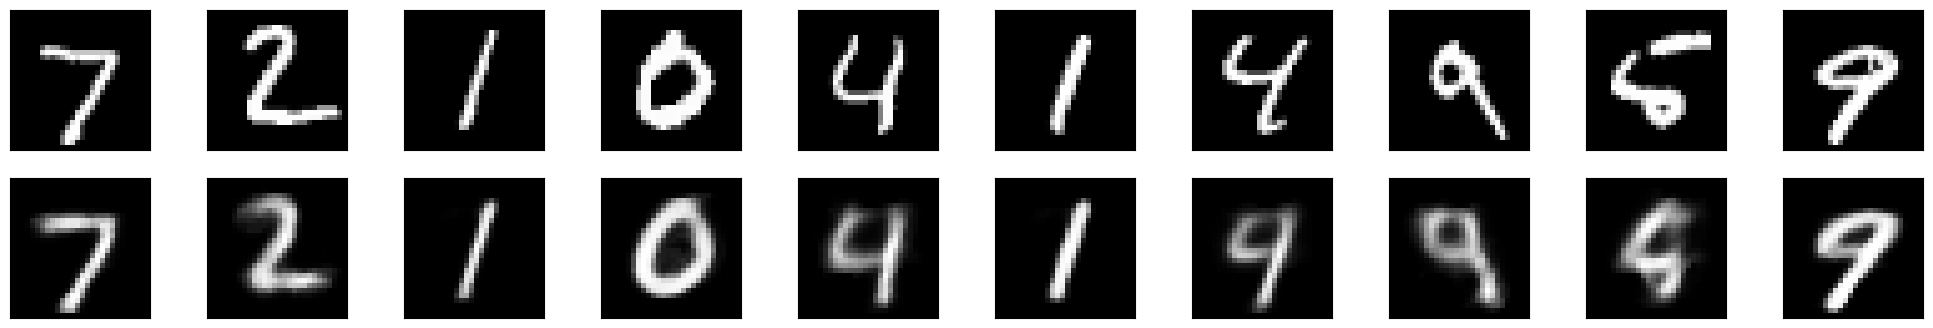

In [33]:
model.eval()
with torch.inference_mode():
  # obtain one batch of test images
  images, labels = next(iter(test_loader))
  # get sample outputs
  output = model(images)
  # prep images for display
  images = images.numpy()
  # output is resized into a batch of images
  output = output.view(images.size(0), 1, 28, 28)
  # use detach when it's an output that requires_grad
  output = output.detach().numpy()
  # plot the first ten input images and then reconstructed images
  fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(25,4))
  # input images on top row, reconstructions on bottom
  for images, row in zip([images, output], axes):
      for img, ax in zip(images, row):
          ax.imshow(np.squeeze(img), cmap='gray')
          ax.get_xaxis().set_visible(False)
          ax.get_yaxis().set_visible(False)